In [1]:
from tools import rasterize_shapefile
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
shapefile = r'/Users/jpnousu/WBT_data/shapes/stream_lengths.shp'
reso = [4, 8, 16, 32]
#reso = [16]

for r in reso: 
    ref_raster = f'/Users/jpnousu/WBT_data/pallas_{r}/korkeusmalli_{r}m_culverts_water_no_deps_flowacc_d8.tif'
    out_raster = f'/Users/jpnousu/WBT_data/pallas_{r}/stream_lengths_burned.tif'
    rasterize_shapefile(shapefile=shapefile, attribute_field='Length', ref_raster=ref_raster, out_raster=out_raster)

Rasterized shapefile saved to: /Users/jpnousu/WBT_data/pallas_4/stream_lengths_burned.tif
Rasterized shapefile saved to: /Users/jpnousu/WBT_data/pallas_8/stream_lengths_burned.tif
Rasterized shapefile saved to: /Users/jpnousu/WBT_data/pallas_16/stream_lengths_burned.tif
Rasterized shapefile saved to: /Users/jpnousu/WBT_data/pallas_32/stream_lengths_burned.tif


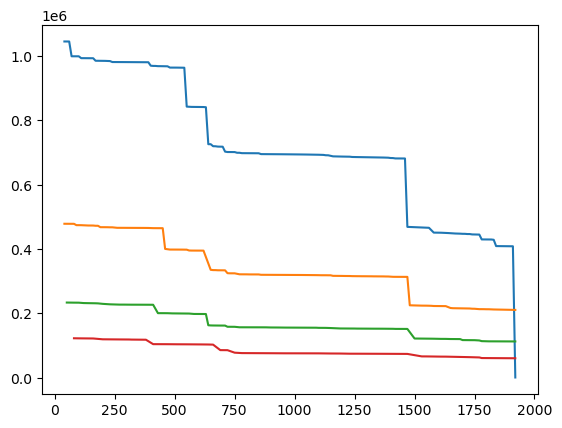

In [3]:
for r in reso:
    flow_acc_file = f'/Users/jpnousu/WBT_data/pallas_{r}/korkeusmalli_{r}m_culverts_water_no_deps_flowacc_d8.tif'
    stream_l_file = f'/Users/jpnousu/WBT_data/pallas_{r}/stream_lengths_burned.tif'
    
    with rasterio.open(flow_acc_file) as src:
        flow_acc = src.read(1)
    with rasterio.open(stream_l_file) as src:
        stream_len = src.read(1)
    stream_len = stream_len.astype('float')
    stream_len[stream_len == 0] = np.nan

    stream_len_1d = np.unique(stream_len)[np.isfinite(np.unique(stream_len))]
    flowacc_1d = pd.DataFrame(index=stream_len_1d)
    flowacc_1d.index.name = 'stream_length'

    flowacc_values = []
    for length in flowacc_1d.index:
        # Mask where stream_len equals current length
        mask = stream_len == length
        # Extract flow_acc values at those positions
        value = flow_acc[mask][0]
        flowacc_values.append(value)
        
    # Assign to the DataFrame
    flowacc_1d['flowacc'] = flowacc_values

    flowacc_sorted = flowacc_1d.sort_index(ascending=False).copy()
    # Keep only non-decreasing flowacc values (downstream flow should be ≥ upstream)
    cleaned = []
    max_acc = -np.inf
    
    for idx, row in flowacc_sorted.iterrows():
        acc = row['flowacc']
        if acc >= max_acc:
            cleaned.append((idx, acc))
            max_acc = acc
        # else: outlier, skip it
    
    # Convert back to DataFrame
    flowacc_cleaned = pd.DataFrame(cleaned, columns=['stream_length', 'flowacc'])
    flowacc_cleaned.set_index('stream_length', inplace=True)
    
    # plot
    plt.plot(flowacc_cleaned.index, flowacc_cleaned['flowacc'])
    
    # save
    out_fp = f'/Users/jpnousu/WBT_data/pallas_{r}/flowacc_1d.csv'
    flowacc_cleaned.to_csv(out_fp)